# COVID-19 Case Data (San Bernardino)

Data provided by California Health and Human Services Open Data Portal: [California COVID-19 Hospital Data and Case Statistics](https://data.chhs.ca.gov/dataset/california-covid-19-hospital-data-and-case-statistics).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import datetime as dt

df = pd.read_csv("data/covid19data.csv")


In [2]:
df_sb = df[df['County Name'] == 'San Bernardino']

#Check data types of columns.
df_sb.dtypes

County Name                              object
Most Recent Date                         object
Total Count Confirmed                   float64
Total Count Deaths                      float64
COVID-19 Positive Patients              float64
Suspected COVID-19 Positive Patients    float64
ICU COVID-19 Positive Patients          float64
ICU COVID-19 Suspected Patients         float64
dtype: object

In [3]:
# Convert to dates to ordinal to avoid errors with datetime objects
df_sb['date_ordinal'] = pd.to_datetime(df['Most Recent Date']).apply(lambda date: date.toordinal())

# Significant dates to be added to graphs
sig_dates = [[dt.date(2020, 5, 23), "Dine-in restaruants open"], [dt.date(2020, 5, 26), "Places of worship, hair salons open"]]
for entry in sig_dates:
    entry[0] = entry[0].toordinal()

C:\Users\shoyr\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


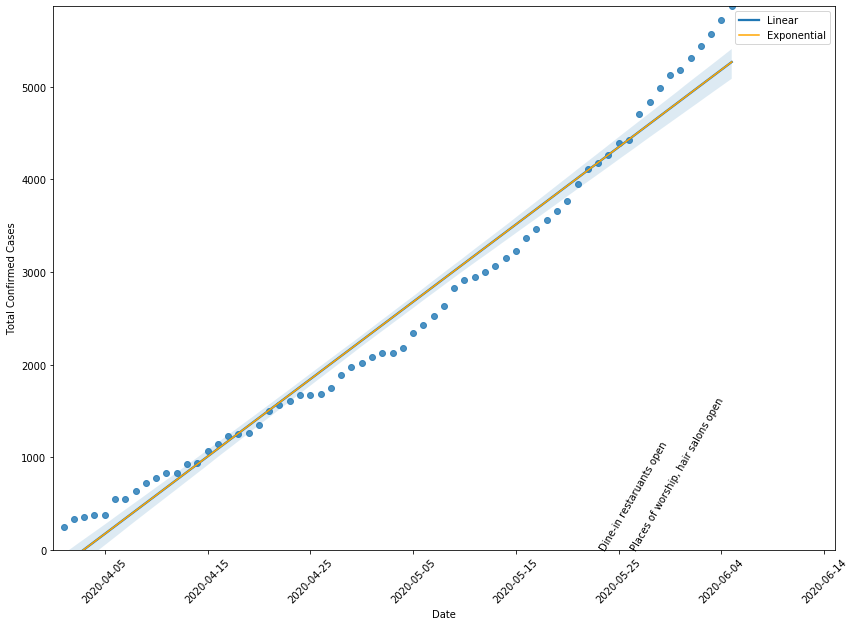

In [4]:
#Plot scatter plot for total case count
x = df_sb['date_ordinal']
y = df_sb['Total Count Confirmed']

plt.figure(figsize=(14,10))
ax = plt.subplot(1,1,1)

sns.regplot(x='date_ordinal', y='Total Count Confirmed', data=df_sb)

# Formatting axes
ax.set_xlim(x.min() - 1, x.max() + 10)
ax.set_ylim(0, y.max() + 1)
ax.set_xlabel('Date')

labels = [dt.date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(labels)
plt.xticks(rotation = 45)
plt.ylabel("Total Confirmed Cases")

#Exponential Curve
def exponential_func(x, a, b, c):
    return a*np.exp(-b*x)+c

popt, pcov = curve_fit(exponential_func, x, y, p0=(1, 1e-6, 1), maxfev=1000000000) 
plt.plot(x, exponential_func(x, *popt), color='orange')
plt.legend(['Linear', 'Exponential'])

# Inserting Significant Date Labels
for entry in sig_dates:
    plt.annotate(entry[1], xy=(entry[0], 0,), rotation=60)

plt.show()

This graph seems to be relatively linear. However, note that there is a slight curve in this data. Since exponential regression displays a near identical trendline to the linear regression line, this will require further investigation with a "better" model.

## New cases per Day

It may be easier to see how the outbreak in San Bernardino County is progressing through comparing case increases between days. Essentially, if the new cases per day is increasing, the spread of the virus is accelerating and vicaversa. Note that I'm speaking in generalities and there may be other factors influencing the data.

In [5]:
# Generate column with new cases.

lag = df_sb['Total Count Confirmed'].shift(1)
df_sb['New Confirmed Cases'] = df_sb['Total Count Confirmed'] - lag
df_sb.head(5)

C:\Users\shoyr\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,County Name,Most Recent Date,Total Count Confirmed,Total Count Deaths,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients,date_ordinal,New Confirmed Cases
1,San Bernardino,4/1/2020,245.0,5.0,95.0,196.0,39.0,52.0,737516,NaN
93,San Bernardino,4/2/2020,335.0,8.0,126.0,185.0,50.0,45.0,737517,90.0
152,San Bernardino,4/3/2020,356.0,11.0,118.0,204.0,44.0,53.0,737518,21.0
211,San Bernardino,4/4/2020,373.0,13.0,138.0,254.0,51.0,66.0,737519,17.0
270,San Bernardino,4/5/2020,375.0,13.0,146.0,240.0,59.0,54.0,737520,2.0


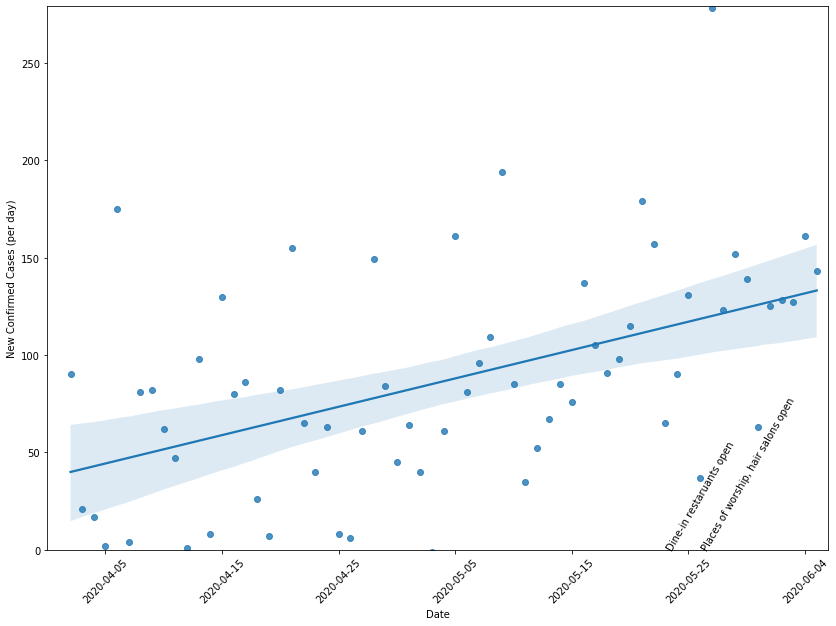

In [6]:
# Plotting new cases per day

plt.figure(figsize=(14,10))
ax = sns.regplot(data=df_sb, x='date_ordinal', y='New Confirmed Cases')

# Formatting
ax.set_xlim(df_sb['date_ordinal'].min() - 1, df_sb['date_ordinal'].max() + 1)
ax.set_ylim(0, df_sb['New Confirmed Cases'].max() + 1)

ax.set_xlabel('Date')
new_labels = [dt.date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
plt.xticks(rotation = 45)
plt.ylabel("New Confirmed Cases (per day)")

# Inserting Significant Date Labels
for entry in sig_dates:
    plt.annotate(entry[1], xy=(entry[0], 0,), rotation=60)

plt.show()

The data suggests a (somewhat tenuous) upward trend in confirmed cases per day in SB county over time. Therefore, the spread of the virus seems to be accelerating just from the graph.

But how strong is this relationship actually? That is, is this relationship statistically significant?

In [17]:
pearsoncorr = df_sb[["date_ordinal", "Total Count Confirmed", "New Confirmed Cases"]].corr(method='pearson')
pearsoncorr

,date_ordinal,Total Count Confirmed,New Confirmed Cases
date_ordinal,1.000000,0.987197,0.492272
Total Count Confirmed,0.987197,1.000000,0.517164
New Confirmed Cases,0.492272,0.517164,1.000000


Since the pearson correlation coefficient for the "date ordinal" and "New Confirmed Cases" columns is low, there is a positive, but relatively weak relationship between time and the number of new cases. That is, the number of new cases per/day seems to be rising, but it doesn't seem to correlate very well to time.

However, we have a much stronger positive relationship between the total confirmed cases and time. This makes sense since the data points from the first graph almost follow a line.